In [1]:
import data_preparation
import matplotlib.pyplot as plt

2022-12-22 16:52:50.147611: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
a, b = data_preparation.get_dataset("div2k/bicubic_x2")

In [15]:
im = next(iter(a))

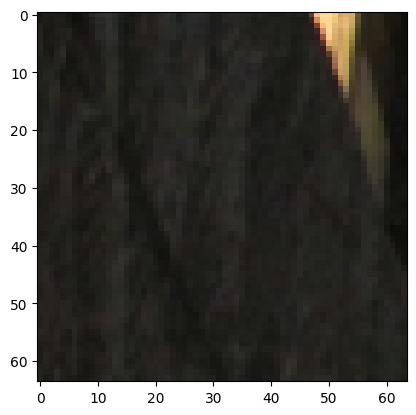

In [16]:
plt.imshow(im[0][0])

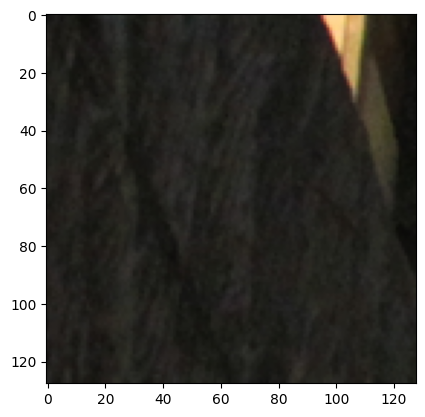

In [17]:
plt.imshow(im[1][0])